In [1]:
!pip install gymnasium
!pip install pygame

# Q-Learning aplicado al entorno Taxi-v3

En este notebook, aplicaremos el algoritmo Q-learning al entorno Taxi-v3 de Gymnasium. Este entorno representa un problema de planificación donde un taxi debe recoger y dejar a un pasajero en una ubicación específica.

## ¿Por qué Taxi-v3 es ideal para Q-learning?

1. **Espacio de estados discreto**: 500 estados posibles (5x5 posiciones del taxi × 5 ubicaciones del pasajero × 4 destinos)
2. **Espacio de acciones discreto**: 6 acciones (norte, sur, este, oeste, recoger, dejar)
3. **Recompensas informativas**: El agente recibe recompensas negativas por cada paso (-1), por intentos ilegales de recoger/dejar (-10) y una recompensa positiva por completar la tarea (+20)
4. **Problema de planificación secuencial**: El agente debe aprender una secuencia óptima de acciones

Este problema representa un desafío más complejo que FrozenLake pero sigue siendo manejable para Q-learning tabular.

In [9]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
from io import StringIO

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Mapeo de acciones a nombres legibles
TAXI_ACTIONS = {
    0: "⬇️ Sur",
    1: "⬆️ Norte",
    2: "➡️ Este",
    3: "⬅️ Oeste",
    4: "🚶 Recoger",
    5: "🏁 Dejar"
}

# Función para visualizar el entorno Taxi con emojis
# Función actualizada para visualizar el entorno Taxi con emojis
def render_taxi_with_emojis(env):
    """Visualiza el entorno Taxi con emojis usando la nueva API de Gymnasium"""
    # Crear un entorno específico para renderización
    render_env = gym.make("Taxi-v3", render_mode="ansi")
    render_env.reset()

    # Copiar el estado del entorno original
    render_env.unwrapped.s = env.unwrapped.s

    # Renderizar y capturar la salida
    taxi_repr = render_env.render()

    # Reemplazar caracteres con emojis
    taxi_repr = taxi_repr.replace("R", "🔴").replace("G", "🟢")
    taxi_repr = taxi_repr.replace("Y", "🟡").replace("B", "🔵")
    taxi_repr = taxi_repr.replace(":", "⬜").replace("|", "⬛")
    taxi_repr = taxi_repr.replace("_", "⬛").replace("-", "⬛")

    # Verificar si hay un pasajero dentro del taxi (diferentes caracteres en la nueva API)
    if "T" in taxi_repr:
        taxi_repr = taxi_repr.replace("T", "🚖")  # Taxi sin pasajero
    else:
        taxi_repr = taxi_repr.replace("t", "🚕")  # Taxi con pasajero

    clear_output(wait=True)
    display(HTML(f"<pre style='font-size: 20px; line-height: 1;'>{taxi_repr}</pre>"))

# Función actualizada para visualizar la política
def visualizar_policy_taxi(agente, max_steps=100):
    """Visualiza la política aprendida con la nueva API de Gymnasium"""
    # Usamos el entorno original para la lógica
    env = agente.env
    Q = agente.Q
    state, _ = env.reset()

    # Crear entorno para visualización
    env_viz = gym.make("Taxi-v3")
    env_viz.reset()
    env_viz.unwrapped.s = state  # Sincronizar estado

    render_taxi_with_emojis(env_viz)

    done = False
    total_reward = 0
    action_sequence = []
    step = 0

    while not done and step < max_steps:
        time.sleep(0.5)  # Pausa para ver la animación
        action = np.argmax(Q[state])
        action_sequence.append(TAXI_ACTIONS[action])
        state, reward, terminated, truncated, _ = env.step(action)

        # Sincronizar el estado del entorno de visualización
        env_viz.unwrapped.s = state
        render_taxi_with_emojis(env_viz)

        done = terminated or truncated
        total_reward += reward
        step += 1

    print(f"Recompensa total: {total_reward}")
    print(f"Pasos realizados: {step}")
    print(f"Secuencia de acciones: {action_sequence}")

# Política epsilon-greedy
def epsilon_greedy_policy(Q, epsilon, state, nA):
    """
    Implementa una política epsilon-greedy basada en los valores Q.
    Con probabilidad 1-epsilon, elige la mejor acción.
    Con probabilidad epsilon, elige una acción aleatoria.
    """
    if random.random() > epsilon:
        return np.argmax(Q[state])
    else:
        return random.randint(0, nA - 1)


# Función para mostrar la política óptima
def obtener_politica_optima(agente):
    """Muestra la mejor acción para cada estado"""
    Q = agente.Q
    n_states = agente.env.observation_space.n
    mejores_acciones = []

    for estado in range(n_states):
        if np.all(Q[estado] == 0):
            mejores_acciones.append('—')  # Estado no visitado
        else:
            accion = np.argmax(Q[estado])
            mejores_acciones.append(TAXI_ACTIONS[accion])

    # Crear una tabla con la política
    datos = []
    for i in range(0, n_states, 50):  # Mostrar de 50 en 50 estados
        fin = min(i + 50, n_states)
        datos.append([f"Estado {j}" for j in range(i, fin)])
        datos.append([mejores_acciones[j] for j in range(i, fin)])

    print("Política óptima (mejores acciones por estado):")
    print("Nota: Se muestran solo algunos estados representativos.")
    return pd.DataFrame(datos)

# Implementación del agente Q-learning

Implementaremos un agente Q-learning para resolver el problema del taxi. El agente aprenderá una función Q que estima el valor de cada par estado-acción.

In [3]:
class AgenteQLearning:
    def __init__(self, env, epsilon=0.1, alpha=0.1, discount_factor=0.99, decay=True):
        self.env = env
        self.epsilon = epsilon  # Exploración
        self.alpha = alpha      # Tasa de aprendizaje
        self.discount_factor = discount_factor  # Factor de descuento
        self.decay = decay      # ¿Decaer epsilon?
        self.nA = env.action_space.n
        self.Q = np.zeros([env.observation_space.n, self.nA])
        self.stats = []
        self.episode_lengths = []

    def entrenar(self, num_episodes=50000, mostrar_barra=True):
        """Entrena el agente usando Q-learning"""
        random.seed(SEED)
        np.random.seed(SEED)

        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            state, _ = self.env.reset(seed=SEED + t)
            done = False
            total_reward = 0
            pasos = 0

            # Decaimiento de epsilon para explorar menos con el tiempo
            if self.decay:
                self.epsilon = max(0.01, 1.0 / (1 + t/1000))

            while not done:
                # Seleccionar acción usando política epsilon-greedy
                action = epsilon_greedy_policy(self.Q, self.epsilon, state, self.nA)

                # Ejecutar acción
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                pasos += 1
                total_reward += reward

                # Actualización de Q-learning
                best_next_action = np.argmax(self.Q[next_state])
                td_target = reward + self.discount_factor * self.Q[next_state, best_next_action] * (not done)
                td_error = td_target - self.Q[state, action]
                self.Q[state, action] += self.alpha * td_error

                state = next_state

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.Q

    def evaluar(self, num_episodios=100, max_steps=200):
        """Evalúa el rendimiento del agente sobre múltiples episodios"""
        total_rewards = []
        total_steps = []
        success_count = 0

        for _ in range(num_episodios):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            steps = 0

            while not done and steps < max_steps:
                action = np.argmax(self.Q[state])  # Política greedy
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                total_reward += reward
                state = next_state
                steps += 1

            if total_reward >= 0:  # Consideramos éxito si la recompensa no es negativa
                success_count += 1

            total_rewards.append(total_reward)
            total_steps.append(steps)

        return {
            'reward_mean': np.mean(total_rewards),
            'reward_std': np.std(total_rewards),
            'steps_mean': np.mean(total_steps),
            'steps_std': np.std(total_steps),
            'success_rate': success_count / num_episodios
        }

# Búsqueda de hiperparámetros óptimos

Realizaremos una búsqueda en cuadrícula para encontrar los mejores hiperparámetros para nuestro agente Q-learning en el entorno Taxi-v3.

In [4]:
def evaluar_configuracion(params):
    """Evalúa una configuración específica de hiperparámetros"""
    env = gym.make("Taxi-v3")
    env.action_space.seed(SEED)
    env.observation_space.seed(SEED)
    env.reset(seed=SEED)

    alpha, gamma, epsilon, decay = params
    agente = AgenteQLearning(env, alpha=alpha, epsilon=epsilon, discount_factor=gamma, decay=decay)
    agente.entrenar(num_episodes=10000, mostrar_barra=False)

    # Evaluar rendimiento
    resultados = agente.evaluar(num_episodios=100)
    return (alpha, gamma, epsilon, decay, resultados['reward_mean'], resultados['success_rate'])

def grid_search_taxi():
    """Busca los mejores hiperparámetros para el entorno Taxi"""
    # Espacio de búsqueda
    alphas = [0.1, 0.2, 0.5]
    gammas = [0.9, 0.95, 0.99]
    epsilons = [0.1, 0.2, 0.5]
    decay = [True, False]
    combinaciones = list(product(alphas, gammas, epsilons, decay))

    mejor_config = None
    mejor_recompensa = -float('inf')
    resultados = []

    print("🔍 Buscando la mejor combinación de hiperparámetros para Taxi-v3...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo) for combo in combinaciones]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, decay_flag, recompensa, tasa_exito = future.result()
            resultados.append((alpha, gamma, epsilon, decay_flag, recompensa, tasa_exito))

            if recompensa > mejor_recompensa:
                mejor_recompensa = recompensa
                mejor_config = (alpha, gamma, epsilon, decay_flag)

    print("\n✅ Mejor configuración encontrada:")
    print(f" alpha = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, decay = {mejor_config[3]}")
    print(f"  → Recompensa media: {mejor_recompensa:.2f}")

    return mejor_config

In [5]:
# Ejecutar búsqueda de hiperparámetros
mejor_config = grid_search_taxi()

🔍 Buscando la mejor combinación de hiperparámetros para Taxi-v3...



Progreso: 100%|██████████| 54/54 [06:05<00:00,  6.77s/it]


✅ Mejor configuración encontrada:
 alpha = 0.1, γ = 0.9, ε = 0.2, decay = False
  → Recompensa media: 8.45


# Entrenamiento del agente con los mejores hiperparámetros

Ahora entrenaremos un agente Q-learning con los hiperparámetros óptimos encontrados en la búsqueda.

In [6]:
# Entrenamiento del agente con la mejor configuración
env_taxi = gym.make("Taxi-v3")
env_taxi.action_space.seed(SEED)
env_taxi.observation_space.seed(SEED)
env_taxi.reset(seed=SEED)

alpha, gamma, epsilon, decay = mejor_config
agente_taxi = AgenteQLearning(
    env_taxi,
    epsilon=epsilon,
    alpha=alpha,
    discount_factor=gamma,
    decay=decay
)

# Entrenamiento con más episodios
agente_taxi.entrenar(num_episodes=50000)

# Evaluar el rendimiento final
resultados_finales = agente_taxi.evaluar(num_episodios=100)
print(f"Resultados de la evaluación final:")
print(f"  → Recompensa media: {resultados_finales['reward_mean']:.2f} ± {resultados_finales['reward_std']:.2f}")
print(f"  → Pasos promedio: {resultados_finales['steps_mean']:.2f} ± {resultados_finales['steps_std']:.2f}")
print(f"  → Tasa de éxito: {resultados_finales['success_rate']*100:.1f}%")

100%|██████████| 50000/50000 [00:27<00:00, 1850.54it/s]

Resultados de la evaluación final:
  → Recompensa media: 8.24 ± 2.69
  → Pasos promedio: 12.76 ± 2.69
  → Tasa de éxito: 100.0%


# Análisis del aprendizaje

Analizaremos cómo el agente ha aprendido a lo largo del entrenamiento mediante gráficas.

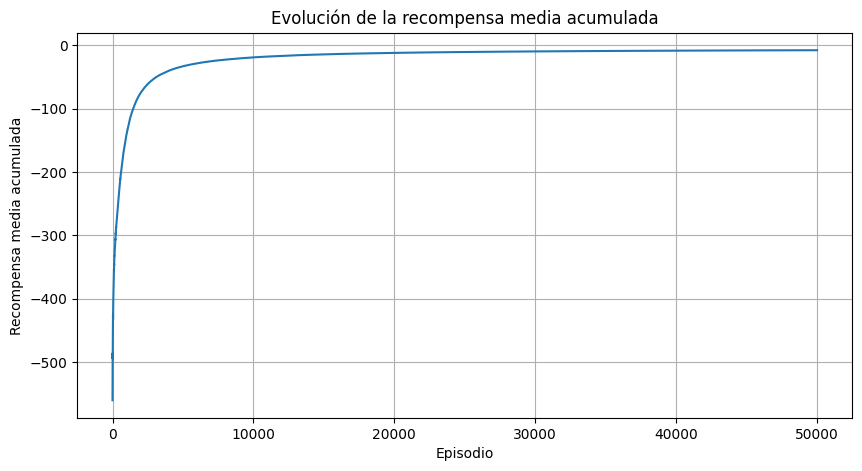

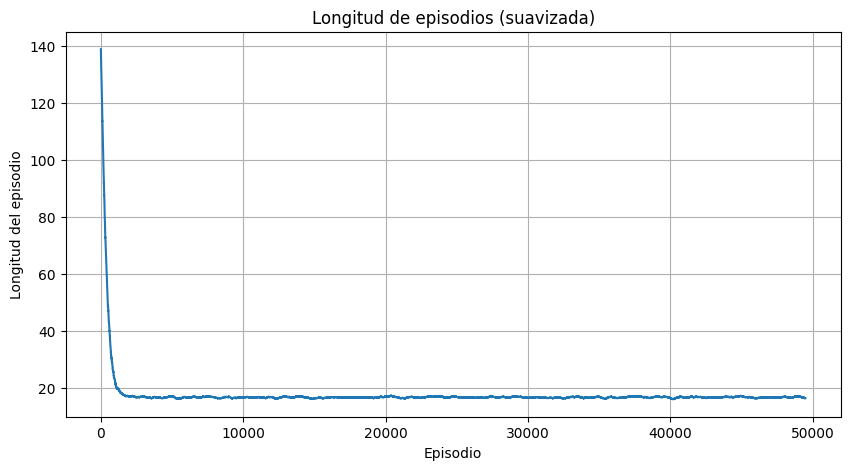

In [7]:
# Función para graficar la proporción de recompensas
def plot_hit_proportion(agente):
    stats = agente.stats
    indices = list(range(len(stats)))
    plt.figure(figsize=(10, 5))
    plt.plot(indices, stats)
    plt.title('Evolución de la recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media acumulada')
    plt.grid(True)
    plt.show()

# Función para graficar la longitud de episodios
def plot_episode_length(agente):
    episode_lengths = agente.episode_lengths
    # Suavizar la gráfica para mayor claridad
    window_size = 500
    smoothed = np.convolve(episode_lengths, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(smoothed)
    plt.title("Longitud de episodios (suavizada)")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud del episodio")
    plt.grid(True)
    plt.show()

# Graficar resultados
plot_hit_proportion(agente_taxi)
plot_episode_length(agente_taxi)

## Interpretación de las gráficas:

1. **Recompensa media acumulada**: La tendencia ascendente indica que el agente ha mejorado progresivamente su rendimiento. La estabilización sugiere que el agente ha convergido a una política cercana a la óptima.

2. **Longitud de episodios**: Inicialmente los episodios son largos e inestables, indicando que el agente está explorando el entorno. A medida que aprende, los episodios se vuelven más cortos y estables, demostrando que ha encontrado rutas más eficientes para completar la tarea.

Estas gráficas confirman que el agente ha aprendido con éxito a resolver el problema del taxi, encontrando políticas que maximizan la recompensa y minimizan el número de pasos necesarios.

# Visualización de la política aprendida

Ahora veremos cómo se comporta el agente siguiendo la política óptima aprendida.

In [10]:
# Visualizar la política aprendida en acción
visualizar_policy_taxi(agente_taxi)

Recompensa total: 7
Pasos realizados: 14
Secuencia de acciones: ['⬇️ Sur', '⬅️ Oeste', '⬇️ Sur', '⬇️ Sur', '⬇️ Sur', '🚶 Recoger', '⬆️ Norte', '⬆️ Norte', '⬅️ Oeste', '⬅️ Oeste', '⬅️ Oeste', '⬇️ Sur', '⬇️ Sur', '🏁 Dejar']


In [11]:
# Analizar los valores Q para algunos estados clave
def analizar_valores_q(agente, estados_clave=None):
    if estados_clave is None:
        # Seleccionar algunos estados representativos para analizar
        estados_clave = [0, 100, 200, 300, 400]

    # Crear una tabla con los valores Q para cada estado y acción
    data = []
    for estado in estados_clave:
        row = [f"Estado {estado}"]
        for accion in range(agente.nA):
            row.append(f"{agente.Q[estado, accion]:.2f}")
        data.append(row)

    # Crear un DataFrame con los valores
    columns = ["Estado"] + [f"{TAXI_ACTIONS[a]}" for a in range(agente.nA)]
    df = pd.DataFrame(data, columns=columns)
    return df

# Mostrar valores Q para estados representativos
df_q_values = analizar_valores_q(agente_taxi)
display(df_q_values)

# Mostrar política óptima para todos los estados
display(obtener_politica_optima(agente_taxi))

,Estado,⬇️ Sur,⬆️ Norte,➡️ Este,⬅️ Oeste,🚶 Recoger,🏁 Dejar
0,Estado 0,0.00,0.00,0.00,0.00,0.00,0.00
1,Estado 100,0.00,0.00,0.00,0.00,0.00,0.00
2,Estado 200,0.00,0.00,0.00,0.00,0.00,0.00
3,Estado 300,0.00,0.00,0.00,0.00,0.00,0.00
4,Estado 400,0.00,0.00,0.00,0.00,0.00,0.00


Política óptima (mejores acciones por estado):
Nota: Se muestran solo algunos estados representativos.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,Estado 0,Estado 1,Estado 2,Estado 3,Estado 4,Estado 5,Estado 6,Estado 7,Estado 8,Estado 9,...,Estado 40,Estado 41,Estado 42,Estado 43,Estado 44,Estado 45,Estado 46,Estado 47,Estado 48,Estado 49
1,—,🚶 Recoger,🚶 Recoger,🚶 Recoger,➡️ Este,—,⬇️ Sur,⬇️ Sur,⬇️ Sur,⬇️ Sur,...,—,⬇️ Sur,⬇️ Sur,⬇️ Sur,➡️ Este,—,➡️ Este,➡️ Este,⬇️ Sur,⬇️ Sur
2,Estado 50,Estado 51,Estado 52,Estado 53,Estado 54,Estado 55,Estado 56,Estado 57,Estado 58,Estado 59,...,Estado 90,Estado 91,Estado 92,Estado 93,Estado 94,Estado 95,Estado 96,Estado 97,Estado 98,Estado 99
3,—,⬇️ Sur,➡️ Este,➡️ Este,➡️ Este,—,⬇️ Sur,➡️ Este,⬇️ Sur,➡️ Este,...,—,⬇️ Sur,⬅️ Oeste,⬅️ Oeste,⬇️ Sur,—,⬅️ Oeste,🏁 Dejar,⬅️ Oeste,⬇️ Sur
4,Estado 100,Estado 101,Estado 102,Estado 103,Estado 104,Estado 105,Estado 106,Estado 107,Estado 108,Estado 109,...,Estado 140,Estado 141,Estado 142,Estado 143,Estado 144,Estado 145,Estado 146,Estado 147,Estado 148,Estado 149
5,—,⬆️ Norte,⬆️ Norte,⬆️ Norte,➡️ Este,—,⬇️ Sur,⬇️ Sur,⬇️ Sur,⬇️ Sur,...,—,⬇️ Sur,⬇️ Sur,⬇️ Sur,➡️ Este,—,➡️ Este,➡️ Este,⬇️ Sur,⬇️ Sur
6,Estado 150,Estado 151,Estado 152,Estado 153,Estado 154,Estado 155,Estado 156,Estado 157,Estado 158,Estado 159,...,Estado 190,Estado 191,Estado 192,Estado 193,Estado 194,Estado 195,Estado 196,Estado 197,Estado 198,Estado 199
7,—,⬇️ Sur,➡️ Este,➡️ Este,⬇️ Sur,—,⬇️ Sur,➡️ Este,⬇️ Sur,⬇️ Sur,...,—,⬇️ Sur,⬇️ Sur,⬅️ Oeste,⬅️ Oeste,—,⬅️ Oeste,⬆️ Norte,⬇️ Sur,⬅️ Oeste
8,Estado 200,Estado 201,Estado 202,Estado 203,Estado 204,Estado 205,Estado 206,Estado 207,Estado 208,Estado 209,...,Estado 240,Estado 241,Estado 242,Estado 243,Estado 244,Estado 245,Estado 246,Estado 247,Estado 248,Estado 249
9,—,⬆️ Norte,⬆️ Norte,⬆️ Norte,➡️ Este,—,➡️ Este,➡️ Este,⬇️ Sur,⬇️ Sur,...,—,⬅️ Oeste,⬅️ Oeste,⬅️ Oeste,➡️ Este,—,➡️ Este,➡️ Este,⬅️ Oeste,⬅️ Oeste


# Comparación con configuraciones subóptimas

Para entender mejor la importancia de los hiperparámetros, entrenaremos brevemente un agente con una configuración subóptima y compararemos su rendimiento.

In [12]:
# Crear un agente con configuración subóptima
env_taxi_suboptimo = gym.make("Taxi-v3")
env_taxi_suboptimo.action_space.seed(SEED)
env_taxi_suboptimo.observation_space.seed(SEED)
env_taxi_suboptimo.reset(seed=SEED)

# Usar valores opuestos a los óptimos
agente_suboptimo = AgenteQLearning(
    env_taxi_suboptimo,
    epsilon=0.9,  # Alta exploración
    alpha=0.01,   # Aprendizaje lento
    discount_factor=0.5,  # Horizonte corto
    decay=False   # Sin decaimiento de epsilon
)

# Entrenar por menos episodios para ver diferencias rápidamente
agente_suboptimo.entrenar(num_episodes=10000)

# Comparar resultados
resultado_optimo = agente_taxi.evaluar(num_episodios=50)
resultado_suboptimo = agente_suboptimo.evaluar(num_episodios=50)

# Crear DataFrame para comparación
comparacion = pd.DataFrame({
    'Métrica': ['Recompensa media', 'Tasa de éxito (%)', 'Pasos promedio'],
    'Configuración óptima': [
        f"{resultado_optimo['reward_mean']:.2f}",
        f"{resultado_optimo['success_rate']*100:.1f}%",
        f"{resultado_optimo['steps_mean']:.1f}"
    ],
    'Configuración subóptima': [
        f"{resultado_suboptimo['reward_mean']:.2f}",
        f"{resultado_suboptimo['success_rate']*100:.1f}%",
        f"{resultado_suboptimo['steps_mean']:.1f}"
    ]
})

display(comparacion)

100%|██████████| 10000/10000 [00:51<00:00, 194.96it/s]


,Métrica,Configuración óptima,Configuración subóptima
0,Recompensa media,7.70,-124.04
1,Tasa de éxito (%),100.0%,36.0%
2,Pasos promedio,13.3,131.6
